# Report

## Introduction and data

> REMOVE THE FOLLOWING TEXT

This section includes an introduction to the project motivation, data, and research question.
Describe the data and definitions of key variables.

It should also include some exploratory data analysis.

All of the EDA won't fit in the paper, so focus on the EDA for the response variable and a few other interesting variables and relationships.

### Setup

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [ ]:
pd.set_option('display.max_colwidth', None)

### Import data

In [ ]:
appearances = pd.read_parquet("../data/raw/appearances.csv")
player_valuations = pd.read_parquet("../data/raw/player_valuations.csv")
transfers = pd.read_parquet("../data/raw/transfers.csv")
players = pd.read_parquet("../data/raw/players.csv")

### Data structure

In [ ]:
print("Appearances columns: \n", appearances.columns)
print("\n Player Valuations columns: \n", player_valuations.columns)
print("\n Transfers columns: \n", transfers.columns)
print("\n Players columns: \n", players.columns)

#### Appearances DataFrame
 **Beschreibung:** Diese Tabelle enthält historische Daten über die Leistungen eines Spielers in einzelnen Spielen.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum des Spiels.
 - `player_name`: Name des Spielers.
 - `competition_id`: ID des Wettbewerbs.
 - `yellow_cards`, `red_cards`: Anzahl gelber und roter Karten.
 - `goals`, `assists`: Tore und Vorlagen im Spiel.
 - `minutes_played`: Anzahl der gespielten Minuten.

In [ ]:
appearances.head(2)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90


#### Player Valuations DataFrame
 **Beschreibung:** Diese Tabelle zeigt die Marktwertentwicklungen der Spieler über die Zeit.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum der Marktwertermittlung.
 - `market_value_in_eur`: Erster Marktwert in Euro.
 - `current_club_id`: ID des aktuellen Clubs.
 - `player_club_domestic_competition_id`: ID des nationalen Wettbewerbs des aktuellen Clubs.


In [ ]:
player_valuations.head(2)

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1


#### Transfers DataFrame
 **Beschreibung:** Diese Tabelle enthält Informationen zu Spielertransfers zwischen Clubs.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `transfer_date`: Datum des Transfers.
 - `transfer_season`: Saison des Transfers.
 - `from_club_id`, `to_club_id`: IDs des abgebenden und aufnehmenden Clubs.
 - `from_club_name`, `to_club_name`: Namen der Clubs.
 - `transfer_fee`: Transfergebühr in Euro.
 - `market_value_in_eur`: Marktwert des Spielers zum Zeitpunkt des Transfers.

In [ ]:
transfers.head(2)

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,195778,2026-06-30,25/26,79,27,VfB Stuttgart,Bayern Munich,0.0,12000000.0,Alexander Nübel
1,569033,2026-06-30,25/26,39,27,1.FSV Mainz 05,Bayern Munich,0.0,4000000.0,Armindo Sieb


#### Players DataFrame
 **Beschreibung:** Diese Tabelle enthält Basisinformationen zu Spielern.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `name`, `first_name`, `last_name`: Name des Spielers.
 - `country_of_birth`, `country_of_citizenship`: Geburtsland und Staatsangehörigkeit.
 - `foot`: Bevorzugter Fuß (rechts/links).
 - `height_in_cm`: Körpergröße in cm.
 - `contract_expiration_date`: Vertragslaufzeitende.
 - `current_club_name`: Name des aktuellen Clubs.
 - `market_value_in_eur`: Aktueller Marktwert in Euro.
 - `highest_market_value_in_eur`: Höchster Marktwert in Euro.

In [ ]:
players.head(2)

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrait/header/10-1448468291.jpg?lm=1,https://www.transfermarkt.co.uk/miroslav-klose/profil/spieler/10,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrait/header/26-1502448725.jpg?lm=1,https://www.transfermarkt.co.uk/roman-weidenfeller/profil/spieler/26,L1,Borussia Dortmund,750000.0,8000000.0


### Data corrections

#### Aggregierte Appearances DataFrame
- **Beschreibung:** Diese Tabelle fasst die Leistungen eines Spielers über alle Spiele zusammen.
- **Aggregierte Spalten:**
  - `minutes_played`: Gesamte Spielminuten.
  - `goals`, `assists`: Gesamte Tore und Vorlagen.
  - `yellow_cards`, `red_cards`: Summe der gelben und roten Karten.


In [ ]:
appearances_agg = appearances.groupby('player_id').agg({
    'minutes_played': 'sum',  # Gesamtminuten
    'goals': 'sum',           # Gesamttore
    'assists': 'sum',         # Gesamtvorlagen
    'yellow_cards': 'sum',    # Gelbe Karten
    'red_cards': 'sum'        # Rote Karten
}).reset_index()

appearances_agg.head()

,player_id,minutes_played,goals,assists,yellow_cards,red_cards
0,10,8808,48,25,19,0
1,26,13508,0,0,4,2
2,65,8788,38,13,11,1
3,77,307,0,0,0,0
4,80,1080,0,0,0,0


#### Fehldende Werte raussuchen

In [ ]:
print("Fehlende Werte in appearances:")
print(appearances.isnull().sum())

Fehlende Werte in appearances:
appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
dtype: int64


In [ ]:
print("Fehlende Werte in player_valuations:")
print(player_valuations.isnull().sum())

Fehlende Werte in player_valuations:
player_id                              0
date                                   0
market_value_in_eur                    0
current_club_id                        0
player_club_domestic_competition_id    0
dtype: int64


In [ ]:
print("Fehlende Werte in transfers:")
print(transfers.isnull().sum())

Fehlende Werte in transfers:
player_id                  0
transfer_date              0
transfer_season            0
from_club_id               0
to_club_id                 0
from_club_name             0
to_club_name               0
transfer_fee           27262
market_value_in_eur    29783
player_name                0
dtype: int64


In [ ]:
print("Fehlende Werte in players:")
print(players.isnull().sum())

Fehlende Werte in players:
player_id                                   0
first_name                               2060
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         2804
city_of_birth                            2464
country_of_citizenship                    380
date_of_birth                              47
sub_position                              183
position                                    0
foot                                     2568
height_in_cm                             2303
contract_expiration_date                12111
agent_name                              15986
image_url                                   0
url                                         0
current_club_domestic_competition_id        0
current_club_name                           0
market_

In [ ]:
players.dropna(subset=['market_value_in_eur'], inplace=True)

#### Merging Datasets

In [ ]:
combined_data = player_valuations.merge(players, on='player_id', how='inner')
combined_data = combined_data.merge(appearances_agg, on='player_id', how='inner')

combined_data = combined_data.merge(transfers[['player_id', 'transfer_fee', 'market_value_in_eur']], 
                                    on='player_id', how='left')


#### Change Datatypes

In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690123 entries, 0 to 1690122
Data columns (total 34 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   player_id                             1690123 non-null  int64  
 1   date                                  1690123 non-null  object 
 2   market_value_in_eur_x                 1690123 non-null  int64  
 3   current_club_id_x                     1690123 non-null  int64  
 4   player_club_domestic_competition_id   1690123 non-null  object 
 5   first_name                            1581432 non-null  object 
 6   last_name                             1690123 non-null  object 
 7   name                                  1690123 non-null  object 
 8   last_season                           1690123 non-null  int64  
 9   current_club_id_y                     1690123 non-null  int64  
 10  player_code                           1690123 non-null

In [ ]:
# Alle IDs als Strings umwandeln
id_columns = [
    "player_id", "player_code", "player_club_domestic_competition_id", 
    "current_club_domestic_competition_id"
]
combined_data[id_columns] = combined_data[id_columns].astype(str)

# Datumsangaben umwandeln
date_columns = ["date", "date_of_birth", "contract_expiration_date"]
for col in date_columns:
    combined_data[col] = pd.to_datetime(combined_data[col], errors='coerce')


print(combined_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690123 entries, 0 to 1690122
Data columns (total 34 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   player_id                             1690123 non-null  object        
 1   date                                  1690123 non-null  datetime64[ns]
 2   market_value_in_eur_x                 1690123 non-null  int64         
 3   current_club_id_x                     1690123 non-null  int64         
 4   player_club_domestic_competition_id   1690123 non-null  object        
 5   first_name                            1581432 non-null  object        
 6   last_name                             1690123 non-null  object        
 7   name                                  1690123 non-null  object        
 8   last_season                           1690123 non-null  int64         
 9   current_club_id_y                     1690123 

#### Feature Engineering

In [ ]:
combined_data.rename(columns={
    'market_value_in_eur_x': 'historical_market_value',
    'market_value_in_eur_y': 'current_market_value',
    'market_value_in_eur': 'transfer_market_value'
}, inplace=True)

In [ ]:
## Feautre Engineering: transfer gap
combined_data['transfer_fee_gap'] = combined_data['transfer_fee'] - combined_data['transfer_market_value']
combined_data.drop(columns=['current_club_id_x', 'current_club_id_y'], inplace=True)

In [ ]:
## Feautre Engineering: Alter
combined_data['age'] = (pd.to_datetime('today').year - 
                         pd.to_datetime(combined_data['date_of_birth']).dt.year)

In [ ]:
combined_data[['date_of_birth', 'age']].head()

,date_of_birth,age
0,1998-01-16,26.0
1,1998-02-13,26.0
2,1980-03-10,44.0
3,1983-11-09,41.0
4,1978-06-09,46.0


In [ ]:
combined_data.head(2)

,player_id,date,historical_market_value,player_club_domestic_competition_id,first_name,last_name,name,last_season,player_code,country_of_birth,...,highest_market_value_in_eur,minutes_played,goals,assists,yellow_cards,red_cards,transfer_fee,transfer_market_value,transfer_fee_gap,age
0,405973,2000-01-20,150000,BE1,Fadel,Gobitaka,Fadel Gobitaka,2017,fadel-gobitaka,Belgium,...,250000.0,4,0,0,0,0,NaN,NaN,NaN,26.0
1,342216,2001-07-20,100000,SC1,Julien,Serrano,Julien Serrano,2020,julien-serrano,France,...,2000000.0,2687,1,4,8,0,NaN,NaN,NaN,26.0


In [ ]:
combined_data.columns

Index(['player_id', 'date', 'historical_market_value',
       'player_club_domestic_competition_id', 'first_name', 'last_name',
       'name', 'last_season', 'player_code', 'country_of_birth',
       'city_of_birth', 'country_of_citizenship', 'date_of_birth',
       'sub_position', 'position', 'foot', 'height_in_cm',
       'contract_expiration_date', 'agent_name', 'image_url', 'url',
       'current_club_domestic_competition_id', 'current_club_name',
       'current_market_value', 'highest_market_value_in_eur', 'minutes_played',
       'goals', 'assists', 'yellow_cards', 'red_cards', 'transfer_fee',
       'transfer_market_value', 'transfer_fee_gap', 'age'],
      dtype='object')

In [ ]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690123 entries, 0 to 1690122
Data columns (total 34 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   player_id                             1690123 non-null  object        
 1   date                                  1690123 non-null  datetime64[ns]
 2   historical_market_value               1690123 non-null  int64         
 3   player_club_domestic_competition_id   1690123 non-null  object        
 4   first_name                            1581432 non-null  object        
 5   last_name                             1690123 non-null  object        
 6   name                                  1690123 non-null  object        
 7   last_season                           1690123 non-null  int64         
 8   player_code                           1690123 non-null  object        
 9   country_of_birth                      1658107 

In [ ]:
# abspeichern in data/processed

combined_data.to_parquet('../data/processed/combined_data.parquet')

#### Variable lists

In [ ]:
features = [
    "height_in_cm", "age", "minutes_played", "goals", "assists", 
    "yellow_cards", "red_cards", "transfer_fee", "transfer_fee_gap", 
    "country_of_citizenship", "foot"
]

target = "current_market_value"

#### Data splitting

In [ ]:
X = pd.get_dummies(combined_data[features], drop_first=True)
y = combined_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Analysis

#### Descriptive statistics

In [ ]:
#combined_data.describe().T

numeric_combined_data = combined_data.select_dtypes(include=["number"])
numeric_combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
historical_market_value,1690123.0,3.848120e+06,8.862498e+06,0.0,300000.0,850000.0,3000000.0,200000000.0
last_season,1690123.0,2.022596e+03,2.717104e+00,2012.0,2023.0,2024.0,2024.0,2024.0
height_in_cm,1676648.0,1.828784e+02,6.975427e+00,18.0,178.0,183.0,188.0,207.0
current_market_value,1690123.0,3.713052e+06,9.350790e+06,10000.0,300000.0,800000.0,3000000.0,200000000.0
highest_market_value_in_eur,1690123.0,9.298985e+06,1.585826e+07,10000.0,1000000.0,3000000.0,10000000.0,200000000.0
minutes_played,1690123.0,9.603298e+03,8.913422e+03,1.0,2285.0,7110.0,14633.0,49595.0
goals,1690123.0,1.536491e+01,2.914370e+01,0.0,0.0,5.0,17.0,490.0
assists,1690123.0,1.148250e+01,1.850402e+01,0.0,1.0,4.0,14.0,224.0
yellow_cards,1690123.0,1.947619e+01,2.067255e+01,0.0,4.0,13.0,29.0,147.0
red_cards,1690123.0,4.819791e-01,8.711311e-01,0.0,0.0,0.0,1.0,8.0


#### Exploratory data analysis

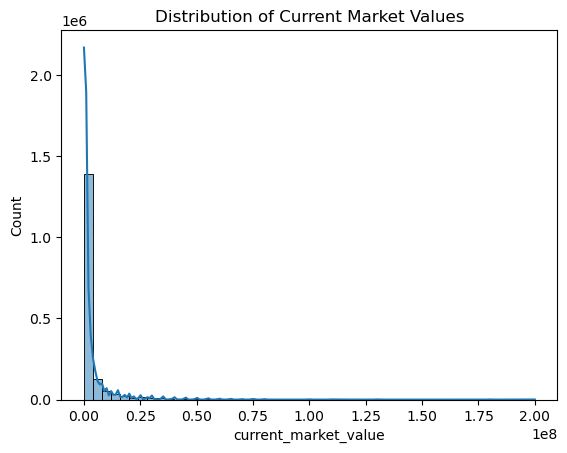

In [ ]:
sns.histplot(combined_data['current_market_value'], bins=50, kde=True)
plt.title("Distribution of Current Market Values")
plt.show()

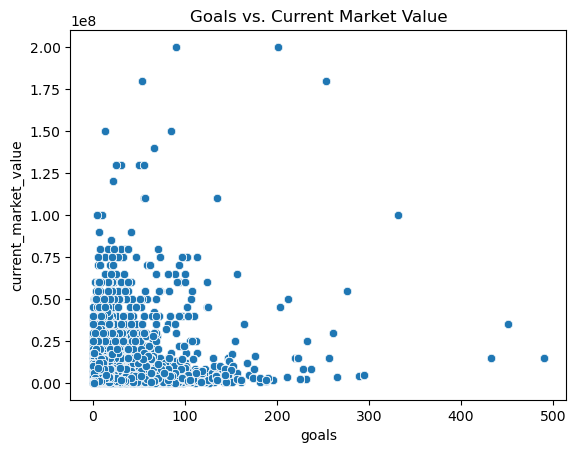

In [ ]:
sns.scatterplot(x='goals', y='current_market_value', data=combined_data)
plt.title("Goals vs. Current Market Value")
plt.show()

#### Relationships

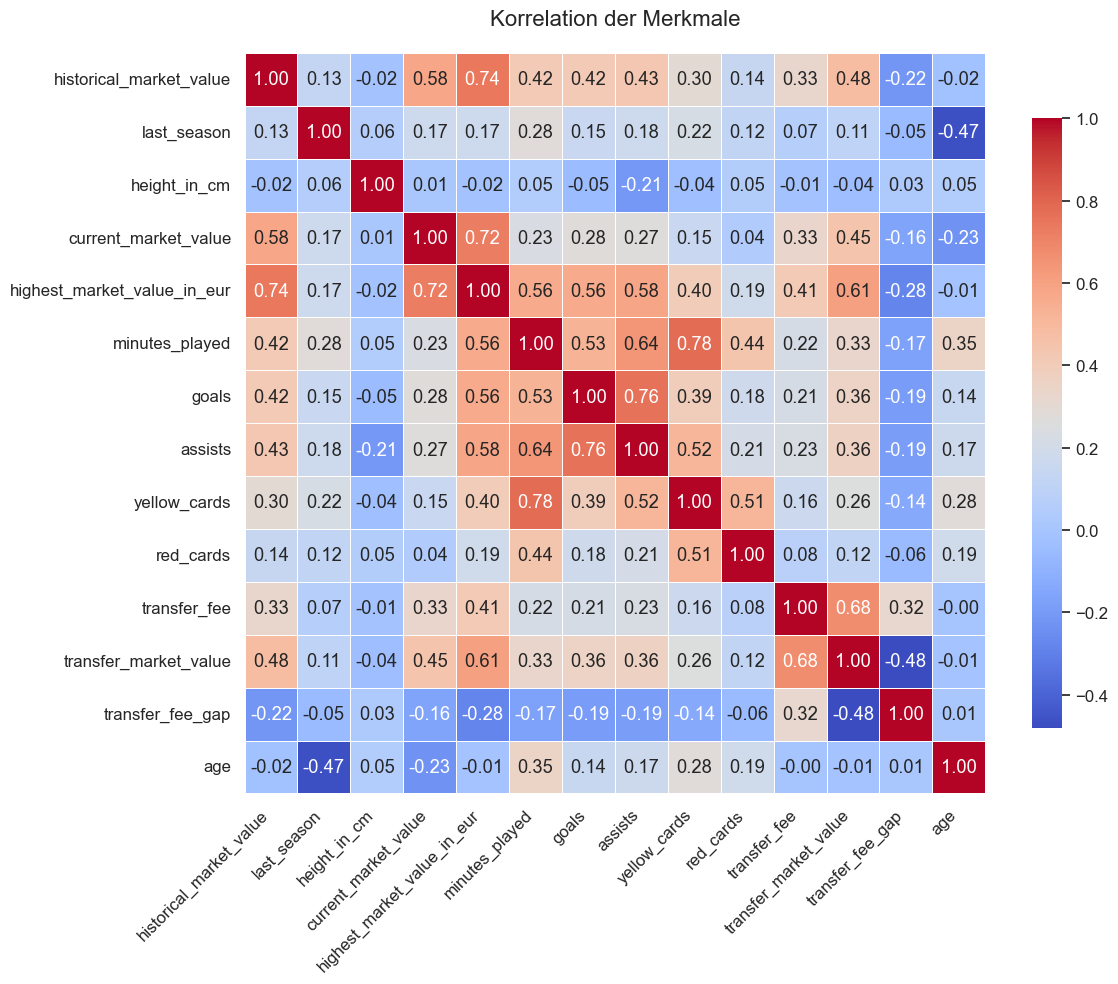

In [ ]:
correlation_matrix = numeric_combined_data.corr()

plt.figure(figsize=(12, 10)) 
sns.set_theme(style="white", font_scale=1.1)

# Heatmap zeichnen
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 0.8},  
    linewidths=0.5, 
    square=True
)

# Titel und Anzeige
plt.title("Korrelation der Merkmale", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()

Die Korrelationsmatrix zeigt die linearen Zusammenhänge zwischen den verschiedenen numerischen Merkmalen des Datensatzes, die zur Vorhersage des Marktwertes von Fußballspielern verwendet werden. Werte nahe 1 oder -1 deuten auf starke positive bzw. negative Korrelationen hin, während Werte nahe 0 auf geringe oder keine Korrelation hinweisen. Beispielsweise zeigt die Variable "highest_market_value_in_eur" mit 0.72 eine starke positive Korrelation mit dem aktuellen Marktwert ("current_market_value"), was intuitiv Sinn ergibt, da der bisher höchste Marktwert eines Spielers ein guter Indikator für dessen aktuellen Marktwert ist. Variablen wie "age" und "red_cards" zeigen eher geringe oder negative Korrelationen, was darauf schließen lässt, dass diese Faktoren weniger stark mit dem Marktwert in Zusammenhang stehen.

## Methodology

> REMOVE THE FOLLOWING TEXT

This section includes a brief description of your modeling process.

Explain the reasoning for the type of model you're fitting, predictor variables considered for the model.

Additionally, show how you arrived at the final model by describing the model selection process, variable transformations (if needed), assessment of conditions and diagnostics, and any other relevant considerations that were part of the model fitting process.

### Select model

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
lr_model = LinearRegression()

### Training and validation

##### Lineare Regression

In [ ]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

height_in_cm                       10808
age                                  624
minutes_played                         0
goals                                  0
assists                                0
                                   ...  
country_of_citizenship_Wales           0
country_of_citizenship_Zambia          0
country_of_citizenship_Zimbabwe        0
foot_left                              0
foot_right                             0
Length: 183, dtype: int64
height_in_cm                       2667
age                                 181
minutes_played                        0
goals                                 0
assists                               0
                                   ... 
country_of_citizenship_Wales          0
country_of_citizenship_Zambia         0
country_of_citizenship_Zimbabwe       0
foot_left                             0
foot_right                            0
Length: 183, dtype: int64


In [ ]:
X__train_filled = X_train.fillna(X.median())
X_test_filled = X_test.fillna(X.median())

In [ ]:
print(f"Länge von X__train_filled: {len(X__train_filled)}")
print(f"Länge von y_train: {len(y_train)}")

Länge von X__train_filled: 1352098
Länge von y_train: 1352098


In [ ]:
lr_model.fit(X__train_filled, y_train)

LinearRegression()

#### RandomForestRegressor

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

### Fit model

In [ ]:
lr_predictions = lr_model.predict(X_test_filled)

In [ ]:
rf_predictions = rf_model.predict(X_test)

## Results

> REMOVE THE FOLLOWING TEXT

This is where you will output the final model with any relevant model fit statistics.

Describe the key results from the model.
The goal is not to interpret every single variable in the model but rather to show that you are proficient in using the model output to address the research questions, using the interpretations to support your conclusions.

Focus on the variables that help you answer the research question and that provide relevant context for the reader.


### Evaluation on test set

In [ ]:
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
print("Linear Regression - Mean Squared Error:", lr_mse)
print("Linear Regression - R-squared:", lr_r2)

Linear Regression - Mean Squared Error: 62027762905142.42
Linear Regression - R-squared: 0.27858921346875387


In [ ]:
# Evaluating the models using Mean Squared Error and R-squared.
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print("Random Forest - Mean Squared Error:", rf_mse)
print("Random Forest - R-squared:", rf_r2)

Random Forest - Mean Squared Error: 12069018314905.797
Random Forest - R-squared: 0.8596318876027951


Der hohe MSE resultiert vor allem aus der Skalierung der Zielvariable, den Marktwerten von Fußballspielern, die teilweise extrem hoch ausfallen. Da der MSE die Fehlerwerte quadriert, wirken sich auch kleinere Abweichungen bei hohen Marktwerten überproportional stark auf das Gesamtergebnis aus. Zusätzlich tragen die große Varianz in den Daten und das Vorhandensein von Outliern – also Spielern mit außergewöhnlich hohen Marktwerten – dazu bei, dass die Fehlerspanne weiter ansteigt. Diese extremen Werte sind schwer vorherzusagen und führen zu einer Verschlechterung des MSE.

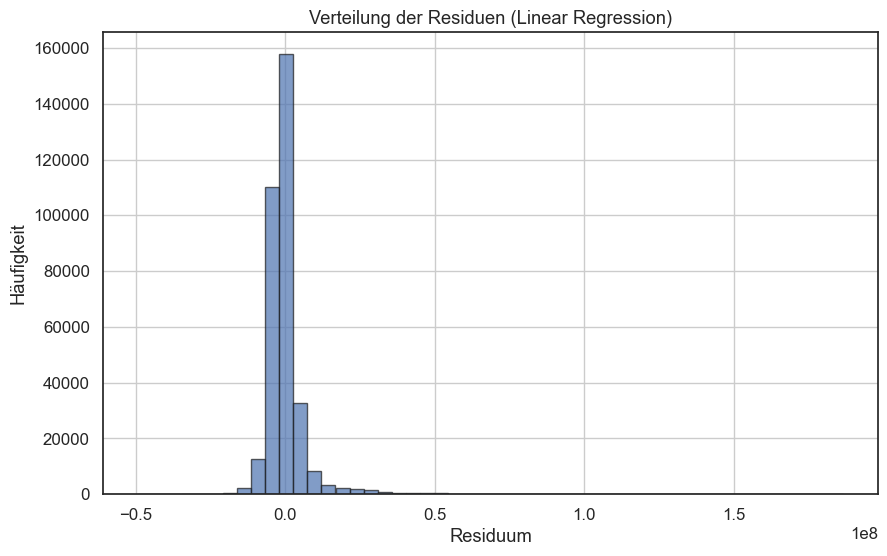

In [ ]:
residuals = y_test - lr_predictions

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen (Linear Regression)")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

Die Verteilung der Residuen zeigt, wie genau ein Modell die tatsächlichen Werte vorhersagen kann. Bei der Linearen Regression ist die Fehlerverteilung zwar symmetrisch um den Wert Null, jedoch deutlich breiter. Dies bedeutet, dass die Lineare Regression größere Fehler (Residuen) produziert. Insbesondere zeigt der rechte Rand der Verteilung, dass das Modell einige Vorhersagen erheblich überschätzt hat. Die Häufigkeit von Residuen nahe Null ist zwar hoch, dennoch führen die großen Fehler dazu, dass die Leistung des Modells beeinträchtigt wird. Diese breitere Streuung deutet darauf hin, dass die Lineare Regression die nichtlinearen und komplexen Zusammenhänge in den Daten nicht ausreichend abbilden kann.

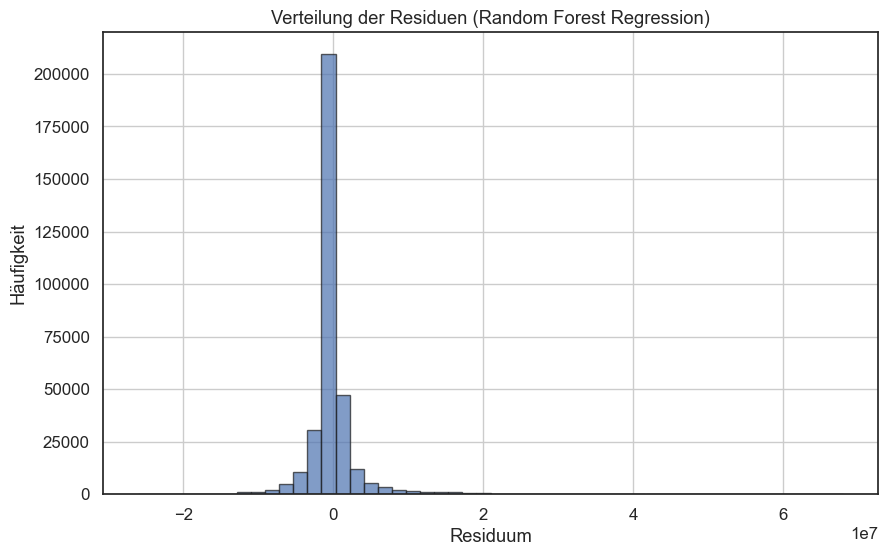

In [ ]:
residuals = y_test - rf_predictions

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen (Random Forest Regression)")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

Im Vergleich dazu zeigt die Random Forest Regression eine wesentlich engere Fehlerverteilung, bei der die meisten Residuen deutlich näher an Null liegen. Dies verdeutlicht, dass die Vorhersagen des Random Forest Modells genauer sind und der Marktwert der Spieler besser approximiert wurde. Die Random Forest Regression ist ein nichtlineares Modell, das in der Lage ist, komplexe Muster und Beziehungen in den Daten besser zu erfassen. Dadurch reduziert es die Anzahl großer Fehler und zeigt eine insgesamt konzentriertere Residuenverteilung mit weniger Ausreißern.

## Discussion + Conclusion


> REMOVE THE FOLLOWING TEXT

In this section you'll include a summary of what you have learned about your research question along with statistical arguments supporting your conclusions.
In addition, discuss the limitations of your analysis and provide suggestions on ways the analysis could be improved.
Any potential issues pertaining to the reliability and validity of your data and appropriateness of the statistical analysis should also be discussed here.
Lastly, this section will include ideas for future work.